In [1]:
import sys, os
if 'google.colab' in sys.modules and not os.path.exists('.setup_complete'):
    !wget -q https://raw.githubusercontent.com/yandexdataschool/Practical_RL/master/setup_colab.sh -O- | bash
    !touch .setup_complete

# This code creates a virtual display to draw game images on.
# It will have no effect if your machine has a monitor.
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY")) == 0:
    !bash ../xvfb start
    os.environ['DISPLAY'] = ':1'

Starting virtual X frame buffer: Xvfb.


### Let's make a TRPO!

In this notebook we will write the code of the one Trust Region Policy Optimization.
As usually, it contains a few different parts which we are going to reproduce.



In [2]:
from typing import Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
import gym

env = gym.make("Acrobot-v1")
env.reset()
observation_shape = env.observation_space.shape
n_actions = env.action_space.n

print("Observation Space", env.observation_space)
print("Action Space", env.action_space)

Observation Space Box(-28.274333953857422, 28.274333953857422, (6,), float32)
Action Space Discrete(3)


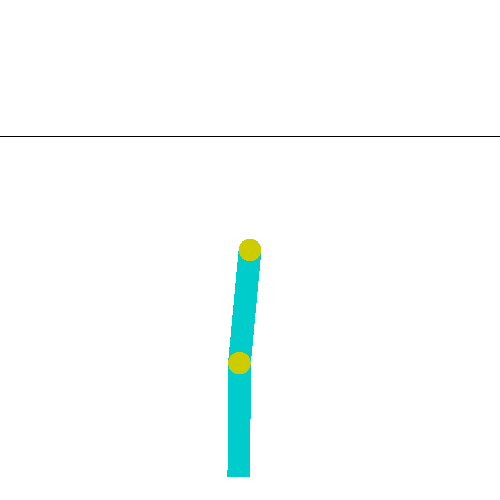

In [4]:
from PIL import Image

Image.fromarray(env.render('rgb_array'))

### Step 1: Defining a network

With all it's complexity, at it's core TRPO is yet another policy gradient method.

This essentially means we're actually training a stochastic policy $\pi_\theta \left( a \middle| s \right)$.

And yes, it's gonna be a neural network. So let's start by defining one.

In [5]:
class TRPOAgent(nn.Module):
    def __init__(self, state_shape: Tuple[int], n_actions: int, hid_size=32):
        '''
        Here you should define your model
        You should have LOG-PROBABILITIES as output because you will need it to compute loss
        We recommend that you start simple:
        use 1-2 hidden layers with 100-500 units and relu for the first try
        '''
        nn.Module.__init__(self)

        assert isinstance(state_shape, tuple)
        assert len(state_shape) == 1
        input_dim = state_shape[0]
        
        # Prepare your model here.
        self.model = nn.Sequential(
            nn.Linear(input_dim, hid_size),
            nn.ReLU(),
            nn.Linear(hid_size, n_actions),
            nn.LogSoftmax(dim=-1)
        )

    def forward(self, states: torch.Tensor):
        """
        takes agent's observation, returns log-probabilities
        :param state_t: a batch of states, shape = [batch_size, state_shape]
        """

        # Use your network to compute log_probs for the given states.
        # <YOUR CODE>
        log_probs = self.model(states)
        
        return log_probs

    def get_log_probs(self, states: torch.Tensor):
        '''
        Log-probs for training
        '''
        return self.forward(states)

    def get_probs(self, states: torch.Tensor):
        '''
        Probs for interaction
        '''
        return torch.exp(self.forward(states))

    def act(self, obs: np.ndarray, sample: bool = True):
        '''
        Samples action from policy distribution (sample = True) or takes most likely action (sample = False)
        :param: obs - single observation vector
        :param sample: if True, samples from \pi, otherwise takes most likely action
        :returns: action (single integer) and probabilities for all actions
        '''

        with torch.no_grad():
            probs = self.get_probs(torch.tensor(obs[np.newaxis], dtype=torch.float32)).numpy()

        if sample:
            action = int(np.random.choice(n_actions, p=probs[0]))
        else:
            action = int(np.argmax(probs))

        return action, probs[0]


agent = TRPOAgent(observation_shape, n_actions, hid_size=256)

In [6]:
# Check if log-probabilities satisfies all the requirements
log_probs = agent.get_log_probs(torch.tensor(env.reset()[np.newaxis], dtype=torch.float32))
assert (
    isinstance(log_probs, torch.Tensor) and
    log_probs.requires_grad
), "log_probs must be a torch.Tensor with grad"
assert log_probs.shape == (1, n_actions)
sums = torch.exp(log_probs).sum(dim=1)
assert torch.allclose(sums, torch.ones_like(sums))

# Demo use
print("sampled:", [agent.act(env.reset()) for _ in range(5)])
print("greedy:", [agent.act(env.reset(), sample=False) for _ in range(5)])

sampled: [(0, array([0.37867326, 0.34924498, 0.27208176], dtype=float32)), (0, array([0.37536764, 0.35253555, 0.2720968 ], dtype=float32)), (2, array([0.37788838, 0.34772328, 0.2743883 ], dtype=float32)), (2, array([0.37860128, 0.34654936, 0.27484944], dtype=float32)), (0, array([0.3808127 , 0.34107754, 0.27810967], dtype=float32))]
greedy: [(0, array([0.37955016, 0.34794334, 0.27250654], dtype=float32)), (0, array([0.37677765, 0.34856832, 0.27465403], dtype=float32)), (0, array([0.38168797, 0.34093246, 0.27737963], dtype=float32)), (0, array([0.3773397 , 0.34874985, 0.27391043], dtype=float32)), (0, array([0.37283576, 0.35356417, 0.27360007], dtype=float32))]


#### Flat parameters operations

We are going to use it

In [7]:
def get_flat_params_from(model):
    params = [torch.ravel(param.detach()) for param in model.parameters()]
    flat_params = torch.cat(params)
    return flat_params


def set_flat_params_to(model, flat_params):
    prev_ind = 0
    for param in model.parameters():
        flat_size = int(np.prod(list(param.shape)))
        param.data.copy_(
            flat_params[prev_ind:prev_ind + flat_size].reshape(param.shape)
        )
        prev_ind += flat_size

Compute cumulative reward just like you did in vanilla REINFORCE

In [8]:
import scipy.signal


def get_cumulative_returns(r, gamma=1):
    """
    Computes cumulative discounted rewards given immediate rewards
    G_i = r_i + gamma*r_{i+1} + gamma^2*r_{i+2} + ...
    Also known as R(s,a).
    """
    r = np.array(r)
    assert r.ndim >= 1
    return scipy.signal.lfilter([1], [1, -gamma], r[::-1], axis=0)[::-1]

In [9]:
# simple demo on rewards [0,0,1,0,0,1]
get_cumulative_returns([0, 0, 1, 0, 0, 1], gamma=0.9)

array([1.40049, 1.5561 , 1.729  , 0.81   , 0.9    , 1.     ])

**Rollout**

In [10]:
def rollout(env, agent, max_pathlength=2500, n_timesteps=50000):
    """
    Generate rollouts for training.
    :param: env - environment in which we will make actions to generate rollouts.
    :param: act - the function that can return policy and action given observation.
    :param: max_pathlength - maximum size of one path that we generate.
    :param: n_timesteps - total sum of sizes of all pathes we generate.
    """
    paths = []

    total_timesteps = 0
    while total_timesteps < n_timesteps:
        obervations, actions, rewards, action_probs = [], [], [], []
        obervation = env.reset()
        for _ in range(max_pathlength):
            action, policy = agent.act(obervation)
            obervations.append(obervation)
            actions.append(action)
            action_probs.append(policy)
            obervation, reward, done, _ = env.step(action)
            rewards.append(reward)
            total_timesteps += 1
            if done or total_timesteps >= n_timesteps:
                path = {
                    "observations": np.array(obervations),
                    "policy": np.array(action_probs),
                    "actions": np.array(actions),
                    "rewards": np.array(rewards),
                    "cumulative_returns": get_cumulative_returns(rewards),
                }
                paths.append(path)
                break
    return paths

In [11]:
from pprint import pprint

paths = rollout(env, agent, max_pathlength=5, n_timesteps=100)
pprint(paths[-1])

assert (paths[0]['policy'].shape == (5, n_actions))
assert (paths[0]['cumulative_returns'].shape == (5,))
assert (paths[0]['rewards'].shape == (5,))
assert (paths[0]['observations'].shape == (5,) + observation_shape)
assert (paths[0]['actions'].shape == (5,))

print("It's ok")

{'actions': array([0, 1, 0, 1, 1]),
 'cumulative_returns': array([-5., -4., -3., -2., -1.]),
 'observations': array([[ 0.99894541, -0.04591364,  0.99605279,  0.08876279, -0.09472404,
         0.01588979],
       [ 0.9990491 , -0.04359933,  0.99904414,  0.04371271,  0.11579802,
        -0.45886475],
       [ 0.9998737 , -0.01589301,  0.99861622, -0.05258935,  0.15268496,
        -0.48350708],
       [ 0.99963825,  0.02689555,  0.98470589, -0.17422487,  0.262336  ,
        -0.71304768],
       [ 0.9975672 ,  0.06971142,  0.95807714, -0.28651036,  0.1548193 ,
        -0.41674623]]),
 'policy': array([[0.37580606, 0.3438832 , 0.28031075],
       [0.37352937, 0.37607673, 0.25039387],
       [0.37630454, 0.37840456, 0.24529096],
       [0.3769973 , 0.39167628, 0.2313264 ],
       [0.38023737, 0.376221  , 0.24354164]], dtype=float32),
 'rewards': array([-1., -1., -1., -1., -1.])}
It's ok


### Step 3: Auxiliary functions

Now let's define the loss functions and something else for actual TRPO training.

The surrogate reward should be:
$$J_{surr}= {1 \over N} \sum\limits_{i=1}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}A_{\theta_{old}(s_i, a_i)}$$

For simplicity, in this assignment we are going to use cumulative rewards instead of advantage:
$$J'_{surr}= {1 \over N} \sum\limits_{i=1}^N \frac{\pi_{\theta}(s_i, a_i)}{\pi_{\theta_{old}}(s_i, a_i)}G_{\theta_{old}(s_i, a_i)}$$

Since we want to maximize the reward, we are going to minimize the corresponding surrogate loss:
$$ L_{surr} = - J'_{surr} $$


In [12]:
def get_loss(agent, observations, actions, cumulative_returns, old_probs):
    """
    Computes TRPO objective
    :param: observations - batch of observations [timesteps x state_shape]
    :param: actions - batch of actions [timesteps]
    :param: cumulative_returns - batch of cumulative returns [timesteps]
    :param: old_probs - batch of probabilities computed by old network [timesteps x num_actions]
    :returns: scalar value of the objective function
    """
    batch_size = observations.shape[0]
    probs_all = agent.get_probs(observations)

    probs_for_actions = probs_all[torch.arange(batch_size), actions]
    old_probs_for_actions = old_probs[torch.arange(batch_size), actions]

    # Compute surrogate loss, aka importance-sampled policy gradient
    loss = -torch.mean(cumulative_returns * (probs_for_actions / old_probs_for_actions))

    assert loss.ndim == 0
    return loss

We can ascend these gradients as long as our $\pi_\theta(a|s)$ satisfies the constraint
$$\mathbb{E}_{s,\pi_{\theta_{t}}} \Big[ \operatorname{KL} \left( \pi_{\theta_{t}} (s) \:\|\: \pi_{\theta_{t+1}} (s) \right) \Big] < \alpha$$


where

$$\operatorname{KL} \left( p \| q \right) = \mathbb{E}_p \log \left( \frac p q \right)$$

In [13]:
def get_kl(agent, observations, actions, cumulative_returns, old_probs):
    """
    Computes KL-divergence between network policy and old policy
    :param: observations - batch of observations [timesteps x state_shape]
    :param: actions - batch of actions [timesteps]
    :param: cumulative_returns - batch of cumulative returns [timesteps] (we don't need it actually)
    :param: old_probs - batch of probabilities computed by old network [timesteps x num_actions]
    :returns: scalar value of the KL-divergence
    """
    batch_size = observations.shape[0]
    log_probs_all = agent.get_log_probs(observations)
    probs_all = torch.exp(log_probs_all)

    # Compute Kullback-Leibler divergence (see formula above).
    # Note: you need to sum KL and entropy over all actions, not just the ones agent took.
    # You will also need to compute max KL over all timesteps.
    old_log_probs = torch.log(old_probs + 1e-10)

    kl = torch.sum(old_probs * (old_log_probs - log_probs_all)) / batch_size

    assert kl.ndim == 0
    assert (kl > -0.0001).all() and (kl < 10000).all()
    return kl

In [14]:
def get_entropy(agent, observations):
    """
    Computes entropy of the network policy
    :param: observations - batch of observations
    :returns: scalar value of the entropy
    """

    observations = torch.tensor(observations, dtype=torch.float32)

    log_probs_all = agent.get_log_probs(observations)
    probs_all = torch.exp(log_probs_all)

    entropy = (-probs_all * log_probs_all).sum(dim=1).mean(dim=0)

    assert entropy.ndim == 0
    return entropy

**Linear search**

TRPO in its core involves ascending surrogate policy gradient constrained by KL divergence.

In order to enforce this constraint, we're gonna use linesearch. You can find out more about it [here](https://en.wikipedia.org/wiki/Linear_search)

In [15]:
def linesearch(f, x: torch.Tensor, fullstep: torch.Tensor, max_kl: float, max_backtracks: int = 10, backtrack_coef: float = 0.5):
    """
    Linesearch finds the best parameters of neural networks in the direction of fullstep contrainted by KL divergence.
    :param: f - function that returns loss, kl and arbitrary third component.
    :param: x - old parameters of neural network.
    :param: fullstep - direction in which we make search.
    :param: max_kl - constraint of KL divergence.
    :returns:
    """
    loss, _, = f(x)
    for stepfrac in backtrack_coef**np.arange(max_backtracks):
        xnew = x + stepfrac * fullstep
        new_loss, kl = f(xnew)
        if kl <= max_kl and new_loss < loss:
            x = xnew
            loss = new_loss
    return x

**Conjugate gradients**

Since TRPO includes contrainted optimization, we will need to solve $A x = b$ using conjugate gradients.

In general, CG is an algorithm that solves $A x = b$ where $A$ is positive-defined. $A$ is the Hessian matrix so $A$ is positive-defined. You can find out more about CG [here](https://en.wikipedia.org/wiki/Conjugate_gradient_method).

In [16]:
def conjugate_gradient(f_Ax, b, cg_iters=10, residual_tol=1e-10):
    """
    This method solves system of equation Ax=b using an iterative method called conjugate gradients
    :f_Ax: function that returns Ax
    :b: targets for Ax
    :cg_iters: how many iterations this method should do
    :residual_tol: epsilon for stability
    """
    p = b.clone()
    r = b.clone()
    x = torch.zeros_like(b)
    rdotr = torch.sum(r*r)
    for i in range(cg_iters):
        z = f_Ax(p)
        v = rdotr / (torch.sum(p*z) + 1e-8)
        x += v * p
        r -= v * z
        newrdotr = torch.sum(r*r)
        mu = newrdotr / (rdotr + 1e-8)
        p = r + mu * p
        rdotr = newrdotr
        if rdotr < residual_tol:
            break
    return x

In [17]:
# This code validates conjugate gradients
A = np.random.rand(8, 8)
A = A.T @ A


def f_Ax(x):
    return torch.ravel(torch.tensor(A, dtype=torch.float32) @ x.reshape(-1, 1))


b = np.random.rand(8)
w = (np.linalg.inv(A.T @ A) @ A.T @ b.reshape(-1, 1)).reshape(-1)

print(w)
print(conjugate_gradient(f_Ax, torch.tensor(b, dtype=torch.float32)).numpy())

[ -0.93378889  -0.55019254 -13.0694146   13.7429897  -11.03312528
 -10.29224396  29.1347946  -18.7284133 ]
[ -0.9338266   -0.55024767 -13.069514    13.74312    -11.033258
 -10.292247    29.135021   -18.728521  ]


### Step 4: training
In this section we construct the whole update step function.

In [18]:
def update_step(agent, observations, actions, cumulative_returns, old_probs, max_kl):
    """
    This function does the TRPO update step
    :param: observations - batch of observations
    :param: actions - batch of actions
    :param: cumulative_returns - batch of cumulative returns
    :param: old_probs - batch of probabilities computed by old network
    :param: max_kl - controls how big KL divergence may be between old and new policy every step.
    :returns: KL between new and old policies and the value of the loss function.
    """

    # Here we prepare the information
    observations = torch.tensor(observations, dtype=torch.float32)
    actions = torch.tensor(actions, dtype=torch.int64)
    cumulative_returns = torch.tensor(cumulative_returns, dtype=torch.float32)
    old_probs = torch.tensor(old_probs, dtype=torch.float32)

    # Here we compute gradient of the loss function
    loss = get_loss(agent, observations, actions, cumulative_returns, old_probs)
    grads = torch.autograd.grad(loss, agent.parameters())
    loss_grad = torch.cat([torch.ravel(grad.detach()) for grad in grads])

    def Fvp(v):
        # Here we compute Fx to do solve Fx = g using conjugate gradients
        # We actually do here a couple of tricks to compute it efficiently

        kl = get_kl(agent, observations, actions, cumulative_returns, old_probs)

        grads = torch.autograd.grad(kl, agent.parameters(), create_graph=True)
        flat_grad_kl = torch.cat([grad.reshape(-1) for grad in grads])

        kl_v = (flat_grad_kl * v).sum()
        grads = torch.autograd.grad(kl_v, agent.parameters())
        flat_grad_grad_kl = torch.cat([torch.ravel(grad) for grad in grads]).detach()

        return flat_grad_grad_kl + v * 0.1

    # Here we solve Fx = g system using conjugate gradients
    stepdir = conjugate_gradient(Fvp, -loss_grad, 10)

    # Here we compute the initial vector to do linear search
    shs = 0.5 * (stepdir * Fvp(stepdir)).sum(0, keepdim=True)

    lm = torch.sqrt(shs / max_kl)
    fullstep = stepdir / lm[0]

    neggdotstepdir = (-loss_grad * stepdir).sum(0, keepdim=True)

    # Here we get the start point
    prev_params = get_flat_params_from(agent)

    def get_loss_kl(params):
        # Helper for linear search
        set_flat_params_to(agent, params)
        return [
            get_loss(agent, observations, actions, cumulative_returns, old_probs),
            get_kl(agent, observations, actions, cumulative_returns, old_probs),
        ]

    # Here we find our new parameters
    new_params = linesearch(get_loss_kl, prev_params, fullstep, max_kl)

    # And we set it to our network
    set_flat_params_to(agent, new_params)

    return get_loss_kl(new_params)

### Step 5: Main TRPO loop

Here we will train our network!

In [ ]:
import time
from itertools import count

# TRPO hyperparameter; controls how big KL divergence may be between the old and the new policy at every step.
max_kl = 0.01
numeptotal = 0  # Number of episodes we have completed so far.

start_time = time.time()

for i in count(1):
    print("\n********** Iteration %i ************" % i)

    # Generating paths.
    print("Rollout")
    paths = rollout(env, agent)
    print("Made rollout")

    # Updating policy.
    observations = np.concatenate([path["observations"] for path in paths])
    actions = np.concatenate([path["actions"] for path in paths])
    returns = np.concatenate([path["cumulative_returns"] for path in paths])
    old_probs = np.concatenate([path["policy"] for path in paths])

    loss, kl = update_step(agent, observations, actions, returns, old_probs, max_kl)

    # Report current progress
    episode_rewards = np.array([path["rewards"].sum() for path in paths])

    stats = {}
    numeptotal += len(episode_rewards)
    stats["Total number of episodes"] = numeptotal
    stats["Average sum of rewards per episode"] = episode_rewards.mean()
    stats["Std of rewards per episode"] = episode_rewards.std()
    stats["Time elapsed"] = "%.2f mins" % ((time.time() - start_time)/60.)
    stats["KL between old and new distribution"] = kl.data.numpy()
    stats["Entropy"] = get_entropy(agent, observations).data.numpy()
    stats["Surrogate loss"] = loss.data.numpy()
    for k, v in stats.items():
        print(k + ": " + " " * (40 - len(k)) + str(v))


********** Iteration 1 ************
Rollout
Made rollout
Total number of episodes:                 102
Average sum of rewards per episode:       -490.1078431372549
Std of rewards per episode:               31.413406299666754
Time elapsed:                             0.82 mins
KL between old and new distribution:      0.009977186
Entropy:                                  1.0603896
Surrogate loss:                           245.52168

********** Iteration 2 ************
Rollout
Made rollout
Total number of episodes:                 206
Average sum of rewards per episode:       -480.5673076923077
Std of rewards per episode:               49.99899314814652
Time elapsed:                             1.37 mins
KL between old and new distribution:      0.009978937
Entropy:                                  1.0513974
Surrogate loss:                           242.56708

********** Iteration 3 ************
Rollout
Made rollout
Total number of episodes:                 322
Average sum of rewards pe

# Homework option I: better sampling (10+pts)

In this section, you're invited to implement a better rollout strategy called _vine_.

![img](https://s17.postimg.cc/i90chxgvj/vine.png)

In most gym environments, you can actually backtrack by using states. You can find a wrapper that saves/loads states in [the MCTS seminar](https://github.com/yandexdataschool/Practical_RL/blob/master/week10_planning/seminar_MCTS.ipynb).

You can read more about TRPO in the [original paper](https://arxiv.org/abs/1502.05477) in section 5.2.

The goal here is to implement such rollout policy (we recommend using tree data structure like in the seminar above).
Then you can assign cumulative rewards similar to `get_cumulative_rewards`, but for a tree.

__bonus task__ - parallelize samples using multiple cores

# Homework option II (10+pts)

Let's use TRPO to train evil robots! (pick any of two)
* [MuJoCo robots](https://gym.openai.com/envs#mujoco)
* [Box2d robot](https://gym.openai.com/envs/BipedalWalker-v2)

The catch here is that those environments have continuous action spaces.

Luckily, TRPO is a policy gradient method, so it's gonna work for any parametric $\pi_\theta(a|s)$. We recommend starting with gaussian policy:

$$\pi_\theta(a|s) = N(\mu_\theta(s),\sigma^2_\theta(s)) = {1 \over \sqrt { 2 \pi {\sigma^2}_\theta(s) } } e^{ (a -
\mu_\theta(s))^2 \over 2 {\sigma^2}_\theta(s) } $$

In the $\sqrt { 2 \pi {\sigma^2}_\theta(s) }$ clause, $\pi$ means ~3.1415926, not agent's policy.

This essentially means that you will need two output layers:
* $\mu_\theta(s)$, a dense layer with linear activation
* ${\sigma^2}_\theta(s)$, a dense layer with activation tf.exp (to make it positive; like rho from bandits)

For multidimensional actions, you can use a fully factorized gaussian (basically a vector of gaussians).

__Bonus task__: compare the performance of the continuous action space method to action space discretization.